## This document demonstrates how to import the python caliper module. The requirements for the Caliperpy package is listed below, copied and pasted directly from the TransCAD 9.0 GISDK help manual:

### TransCAD 9.0 Caliperpy installation instructions
Installing the Caliper Python Module
To program TransCAD in Python, you need:

TransCAD Version 9 or later
A Windows distribution of Python, version 3.x. At the time of writing, the latest Python version was 3.8. For example:
Anaconda Python for Windows, download at https://www.anaconda.com/download/
ActiveState Python, download at http://www.activestate.com/products/activepython
The Caliper Python Installer: C:\Program Files\TransCAD 2020\GISDK\Samples\Python\CaliperPy-v[yyyy-mm].win-amd64.exe
 

You can run the Caliper Python Installer once to install the CaliperPy package globally in your local Python program site-package folder.

 

The CaliperPy module use DCOM as a connection between TransCAD and Python. That means that DCOM must be enabled on your computer, and that the security settings for the DCOM objects "TransCAD.AutomationServer" and "TransCAD.AutomationServer (secondary)" must allow launch and access by users of your computer.

In [1]:
import caliper, caliperpy, traceback, sys
import numpy as np
import pandas as pd
import pandas as pd
from siuba import *
from siuba import group_by, summarize, _
from plotnine import ggplot, aes, geom_line
import os
from plotnine import *

pd.set_option('display.float_format', lambda x: '%.3f' % x)
#git instructions - open terminal in jupyternotebook
## cd "C:/Users/JacobFo/OneDrive - City of Durham/Python/TRMG2"


In [2]:

dk = caliperpy.TransCAD.connect()

Connecting to TransCAD...


## Highway Assignment Checks TRMG2

Goal: Replicate the current TRMv6.2 summary tool and evaluation report's key metrics, while developing tool to replicate in TRMG2 format. 



 

In [3]:
path = "c:/Users/JacobFo/TRMG2_v0.1/scenarios/base_2016/output/networks/"
inpFname =  os.path.join(path, "scenario_links.bin")
hwy_2016_g2 = dk.GetDataFrameFromBin(inpFname)



path = "c:/Users/JacobFo/OneDrive - City of Durham/Full Model Runs/Original TRMv6.2_2016 - Copy/"
inpFname =  os.path.join(path, "Input/Highway/Highway_Line.bin")
hwy_2016_v6 = dk.GetDataFrameFromBin(inpFname)

replace_nas = hwy_2016_v6

replace_nas.fillna(value = 0,inplace = True)

replace_nas['TotVMT'] = replace_nas['ABAMVMT']+replace_nas['ABMDVMT']+replace_nas['ABNTVMT']+replace_nas['ABPMVMT']+replace_nas['BAAMVMT']+replace_nas['BAMDVMT']+replace_nas['BANTVMT']+replace_nas['BAPMVMT']

replace_nas['TotVHT'] = replace_nas['ABAMVHT']+replace_nas['ABMDVHT']+replace_nas['ABNTVHT']+replace_nas['ABPMVHT']+replace_nas['BAAMVHT']+replace_nas['BAMDVHT']+replace_nas['BANTVHT']+replace_nas['BAPMVHT']



# Vehicle Miles Traveled 

### Total VMT: TRMv6.2


In [4]:
vmt_v6_total = replace_nas['TotVMT'].sum()
vmt_v6_total

56927558.91335465

### Total VMT: TRMG2

In [5]:
vmt_g2_total=hwy_2016_g2['Total_VMT_Daily'].sum()
vmt_g2_total

56941195.208005026

Percent Difference: (G2 - v6.2)/ G2

In [6]:
((vmt_g2_total-vmt_v6_total)/vmt_g2_total)*100

0.02394803024517265

### Total VMT by MPO: TRMv6.2

In [7]:
vmt_mpo_v6 = (
replace_nas 
    >>group_by(MPO = _.MPO)
    >>summarize(Total_VMT_v6 = _.TotVMT.sum())
)


vmt_mpo_v6 = (
vmt_mpo_v6
    >>arrange(_.MPO)
)


vmt_mpo_v6

,MPO,Total_VMT_v6
0,0,7864112.068
1,1,34546729.400
2,2,14516717.446


### Total VMT by MPO: TRMG2

- missing from TRMG2 line and TAZ layer, will need to circle around to tag

### Total VMT by County

In [8]:

replace_nas['New_County'] = replace_nas['COUNTY'].str.lower()

vmt_county_v6 = (
replace_nas 
    >>group_by(County = _.New_County)
    >>summarize(Total_VMT_v6 = _.TotVMT.sum())
)

## add missing alamance to compare to TRMG2
vmt_county_v6.loc[len(vmt_county_v6.index)] = ['alamance', 0] 

vmt_county_v6 = (
vmt_county_v6
    >>arrange(_.County)
)




hwy_2016_g2['New_County'] = hwy_2016_g2['County'].str.lower()

vmt_county_g2 = (
hwy_2016_g2 
    >>group_by(County = _.New_County)
    >>summarize(Total_VMT_G2 =_.Total_VMT_Daily.sum()              
))

vmt_county_g2.loc[len(vmt_county_g2.index)] = ['external', 0] 

vmt_county_g2 = (
vmt_county_g2
    >>arrange(_.County)
)

county_comparison = pd.merge(vmt_county_v6, vmt_county_g2, on="County")
county_comparison['Difference'] = county_comparison['Total_VMT_G2']-county_comparison['Total_VMT_v6']
county_comparison['PctDifference'] = ((county_comparison['Total_VMT_G2']-county_comparison['Total_VMT_v6'])/county_comparison['Total_VMT_G2'])*100
county_comparison

,County,Total_VMT_v6,Total_VMT_G2,Difference,PctDifference
0,alamance,0.000,851441.856,851441.856,100.000
1,chatham,1887084.185,1773993.398,-113090.787,-6.375
2,durham,9579639.353,8975801.833,-603837.521,-6.727
3,external,145264.996,0.000,-145264.996,-inf
4,franklin,1482186.218,1542338.060,60151.842,3.900
5,granville,1311675.053,1244674.655,-67000.398,-5.383
6,harnett,1099687.873,1066412.661,-33275.212,-3.120
7,johnston,6071384.148,5836881.100,-234503.048,-4.018
8,nash,250834.738,205933.509,-44901.229,-21.804
9,orange,5220110.193,4675084.773,-545025.419,-11.658


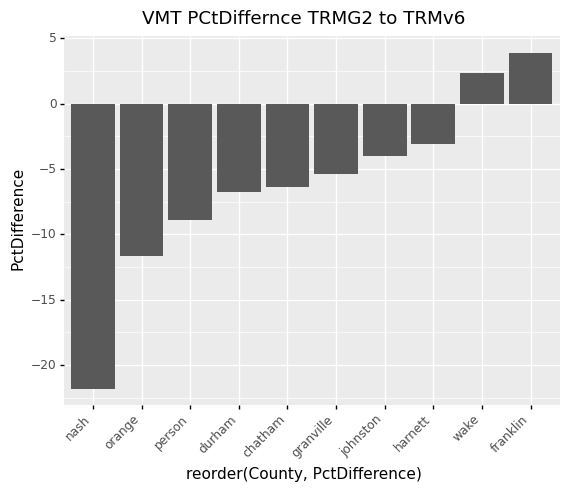

<ggplot: (95273172800)>

In [9]:
(
county_comparison
    >>arrange(-_.PctDifference)
    >>filter(_.County !="alamance")
    >>filter(_.County !="external")
    >>ggplot(aes('reorder(County, PctDifference)', "PctDifference"))+geom_col()+ theme(axis_text_x = element_text(angle = 45 , hjust=1)) +ggtitle("VMT PCtDiffernce TRMG2 to TRMv6")

)


# Vehicle Hours Traveled

### Total VHT: TRMv6.2

In [10]:
vht_v6_total = replace_nas['TotVHT'].sum()
vht_v6_total

1415882.0878761539

### Total VHT: TRMG2

In [11]:
vht_g2_total = hwy_2016_g2['Total_VHT_Daily'].sum()
vht_g2_total

1207677.1703346632

### Total VHT by County

In [12]:
vht_county_v6 = (
replace_nas 
    >>group_by(County = _.New_County)
    >>summarize(Total_VHT_v6 = _.TotVHT.sum())
)

## add missing alamance to compare to TRMG2
vht_county_v6.loc[len(vht_county_v6.index)] = ['alamance', 0] 

vht_county_v6 = (
vht_county_v6
    >>arrange(_.County)
)


hwy_2016_g2['New_County'] = hwy_2016_g2['County'].str.lower()

vht_county_g2 = (
hwy_2016_g2 
    >>group_by(County = _.New_County)
    >>summarize(Total_VHT_G2 =_.Total_VHT_Daily.sum()              
))

vht_county_g2.loc[len(vmt_county_g2.index)] = ['external', 0] 

vht_county_g2 = (
vht_county_g2
    >>arrange(_.County)
)

county_comparison = pd.merge(vht_county_v6, vht_county_g2, on="County")
county_comparison['Difference'] = county_comparison['Total_VHT_G2']-county_comparison['Total_VHT_v6']
county_comparison['PctDifference'] = ((county_comparison['Total_VHT_G2']-county_comparison['Total_VHT_v6'])/county_comparison['Total_VHT_G2'])*100

county_comparison


,County,Total_VHT_v6,Total_VHT_G2,Difference,PctDifference
0,alamance,0.000,21148.201,21148.201,100.000
1,chatham,38290.331,33177.573,-5112.757,-15.410
2,durham,246640.255,196089.130,-50551.125,-25.780
3,external,3321.714,0.000,-3321.714,-inf
4,franklin,32199.822,30902.817,-1297.005,-4.197
5,granville,25698.701,23789.886,-1908.815,-8.024
6,harnett,24472.330,22667.775,-1804.555,-7.961
7,johnston,124541.795,108610.210,-15931.585,-14.669
8,nash,4109.596,3254.710,-854.886,-26.266
9,orange,122548.292,100386.650,-22161.642,-22.076


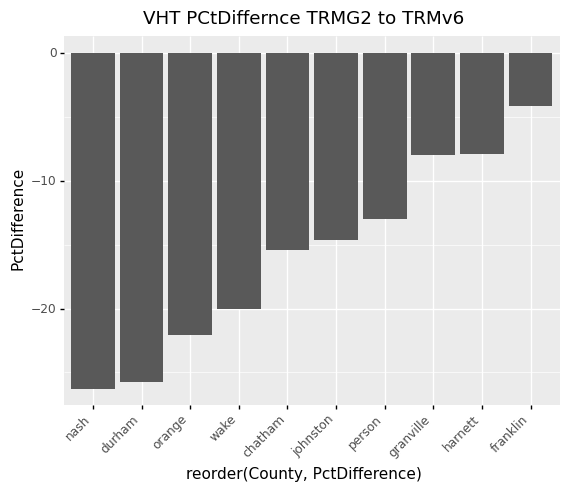

<ggplot: (95276692234)>

In [13]:

(
county_comparison
    >>arrange(-_.PctDifference)
    >>filter(_.County !="alamance")
    >>filter(_.County !="external")
    >>ggplot(aes('reorder(County, PctDifference)', "PctDifference"))+geom_col()+ theme(axis_text_x = element_text(angle = 45 , hjust=1)) +ggtitle("VHT PCtDiffernce TRMG2 to TRMv6")

)


# Total Daily Volume - All Links


### Total Daily Volume: TRMv6.2

In [14]:
tot_vol_v6_total = replace_nas['ToTDlyVol'].sum()
tot_vol_v6_total

186392885.39225224

### Total Daily Volume: TRMG2

In [15]:
tot_vol_g2_total = hwy_2016_g2['Total_Flow_Daily'].sum()
tot_vol_g2_total

293661262.0148999

### Total Daily Volume by County

In [16]:
tot_vol_county_v6 = (
replace_nas 
    >>group_by(County = _.New_County)
    >>summarize(Total_Flow_v6 = _.ToTDlyVol.sum())
)

## add missing alamance to compare to TRMG2
tot_vol_county_v6.loc[len(tot_vol_county_v6.index)] = ['alamance', 0] 

tot_vol_county_v6 = (
tot_vol_county_v6
    >>arrange(_.County)
)


hwy_2016_g2['New_County'] = hwy_2016_g2['County'].str.lower()

tot_vol_county_g2 = (
hwy_2016_g2 
    >>group_by(County = _.New_County)
    >>summarize(Total_Flow_G2 =_.Total_Flow_Daily.sum()              
))

tot_vol_county_g2.loc[len(tot_vol_county_g2.index)] = ['external', 0] 

tot_vol_county_g2 = (
tot_vol_county_g2
    >>arrange(_.County)
)

county_comparison = pd.merge(tot_vol_county_v6, tot_vol_county_g2, on="County")
county_comparison['Difference'] = county_comparison['Total_Flow_G2']-county_comparison['Total_Flow_v6']
county_comparison['PctDifference'] = ((county_comparison['Total_Flow_G2']-county_comparison['Total_Flow_v6'])/county_comparison['Total_Flow_G2'])*100

county_comparison


,County,Total_Flow_v6,Total_Flow_G2,Difference,PctDifference
0,alamance,0.000,4515459.599,4515459.599,100.000
1,chatham,2498666.222,5578278.216,3079611.994,55.207
2,durham,43217816.601,55005948.333,11788131.732,21.431
3,external,676773.888,0.000,-676773.888,-inf
4,franklin,2665561.592,8179729.986,5514168.394,67.413
5,granville,1775753.358,3612674.614,1836921.257,50.847
6,harnett,1930055.644,5094912.909,3164857.265,62.118
7,johnston,10281901.428,19967056.585,9685155.157,48.506
8,nash,249296.364,431550.771,182254.408,42.232
9,orange,15895967.235,21542834.709,5646867.473,26.212


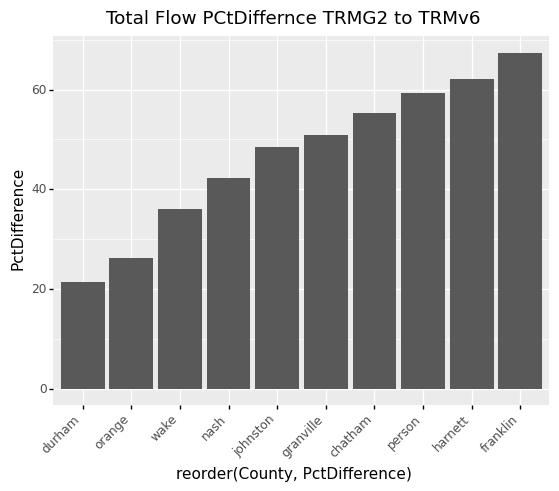

<ggplot: (95272381510)>

In [17]:

(
county_comparison
    >>arrange(-_.PctDifference)
    >>filter(_.County !="alamance")
    >>filter(_.County !="external")
    >>ggplot(aes('reorder(County, PctDifference)', "PctDifference"))+geom_col()+ theme(axis_text_x = element_text(angle = 45 , hjust=1)) +ggtitle("Total Flow PCtDiffernce TRMG2 to TRMv6")

)


# Total Daily Volume - Links with Counts

### Total Daily Volume: TRMv6.2

In [18]:
inpFname =  os.path.join(path, "EvalModule/TRM6_Count_2016_Observed.bin")
count = dk.GetDataFrameFromBin(inpFname)

temp = (
count 
    >>select(_.ID, _.Daily_Counts)
)

temp = pd.merge(replace_nas, temp)

hwy_2016_v6_counts = (
temp
    >>filter(_.Daily_Counts > 0)
)

tot_vol_v6_total = hwy_2016_v6_counts['ToTDlyVol'].sum()
tot_vol_v6_total



52528713.675038055

### Total Daily Volume: TRMG2

In [19]:
hwy_2016_g2_counts = (
hwy_2016_g2
    >>filter(_.DailyCount>0)
)

tot_vol_g2_total = hwy_2016_g2_counts['Total_Flow_Daily'].sum()
tot_vol_g2_total

52909140.477534674

Percent Difference

In [20]:
((tot_vol_g2_total-tot_vol_v6_total)/tot_vol_g2_total)*100

0.7190190561839679

In [21]:
tot_vol_county_v6 = (
hwy_2016_v6_counts 
    >>group_by(County = _.New_County)
    >>summarize(Total_Flow_v6 = _.ToTDlyVol.sum(),
               Total_Counts_v6 = _.Daily_Counts.sum())
    >>mutate(PctDifference = (_.Total_Flow_v6 - _.Total_Counts_v6)/_.Total_Flow_v6*100)
)


hwy_2016_g2_counts['New_County'] = hwy_2016_g2_counts['County'].str.lower()

tot_vol_county_g2 = (
hwy_2016_g2_counts 
    >>group_by(County = _.New_County)
    >>summarize(Total_Flow_G2 =_.Total_Flow_Daily.sum(),
                Total_Counts_G2 = _.DailyCount.sum())
    >>mutate(PctDifference = (_.Total_Flow_G2 - _.Total_Counts_G2)/_.Total_Flow_G2*100)
)


tot_vol_county_g2.loc[len(tot_vol_county_g2.index)] = ['external', 0,0,0] 

tot_vol_county_g2 = (
tot_vol_county_g2
    >>arrange(_.County)
)

county_comparison = pd.merge(tot_vol_county_v6, tot_vol_county_g2, on="County")

county_comparison['Difference'] = county_comparison['Total_Flow_G2']-county_comparison['Total_Flow_v6']
county_comparison['PctDifference'] = ((county_comparison['Total_Flow_G2']-county_comparison['Total_Flow_v6'])/county_comparison['Total_Flow_G2'])*100

tot_flow_county = (
county_comparison
    >>select(_.County, _.Total_Flow_v6, _.Total_Flow_G2, _.PctDifference)
)
tot_flow_county

<ipython-input-21-bde943d44b36>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,County,Total_Flow_v6,Total_Flow_G2,PctDifference
0,chatham,845870.512,847316.179,0.171
1,durham,12016011.959,11807839.924,-1.763
2,external,104807.179,0.000,-inf
3,franklin,979763.419,1001854.161,2.205
4,granville,674119.029,687433.617,1.937
5,harnett,728257.696,702161.546,-3.717
6,johnston,3509072.787,3502112.797,-0.199
7,nash,124308.538,70556.855,-76.182
8,orange,4007723.588,3813678.699,-5.088
9,person,644518.160,596909.643,-7.976


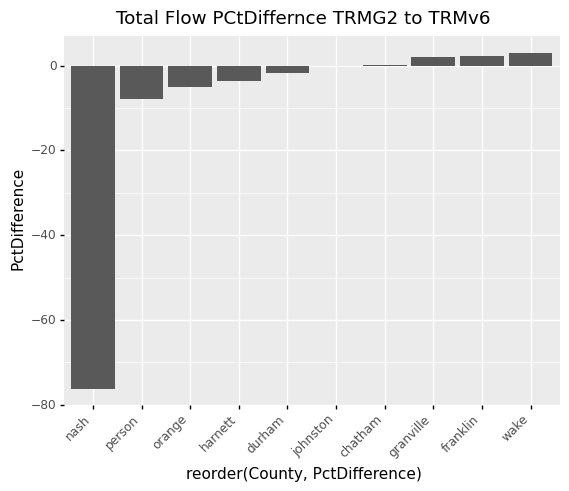

<ggplot: (95273444524)>

In [22]:

(
tot_flow_county
    >>arrange(-_.PctDifference)
    >>filter(_.County !="alamance")
    >>filter(_.County !="external")
   # >>ggplot(aes("County", "PctDifference"))+geom_col()+ theme(axis_text_x = element_text(angle = 45 , hjust=1)) +ggtitle("Total Flow PCtDiffernce TRMG2 to TRMv6")
     >>ggplot(aes('reorder(County, PctDifference)', "PctDifference"))+geom_col()+ theme(axis_text_x = element_text(angle = 45 , hjust=1)) +ggtitle("Total Flow PCtDiffernce TRMG2 to TRMv6")
)


# Total Flow by Facility Type

## TRMv6.2

In [75]:
hwy_2016_v6_counts['FCGroup_Tag'] = case_when(hwy_2016_v6_counts, {
    _.FCGROUP ==1 : "Freeway",
    _.FCGROUP ==2 : "Major Arterial",
    _.FCGROUP ==3: "Minor Arterial",
    _.FCGROUP ==4: "Collector",
    _.FCGROUP ==5: "Local",
    True: "CC"
})

tot_vol_fcgroup_v6 = (
hwy_2016_v6_counts 
    >>group_by(_.FCGroup_Tag)
    >>filter(_.FCGroup_Tag !="CC")
    >>summarize(Total_Flow_v6 = _.ToTDlyVol.sum(),
               Total_Counts_v6 = _.Daily_Counts.sum())
    >>mutate(PctDifference = (_.Total_Flow_v6 - _.Total_Counts_v6)/_.Total_Flow_v6*100)
)
tot_vol_fcgroup_v6

,FCGroup_Tag,Total_Flow_v6,Total_Counts_v6,PctDifference
0,Collector,6441993.944,6623550,-2.818
1,Freeway,14257957.000,14084500,1.217
2,Local,4735795.867,4655830,1.689
3,Major Arterial,13835060.618,15284820,-10.479
4,Minor Arterial,13151478.378,13397660,-1.872


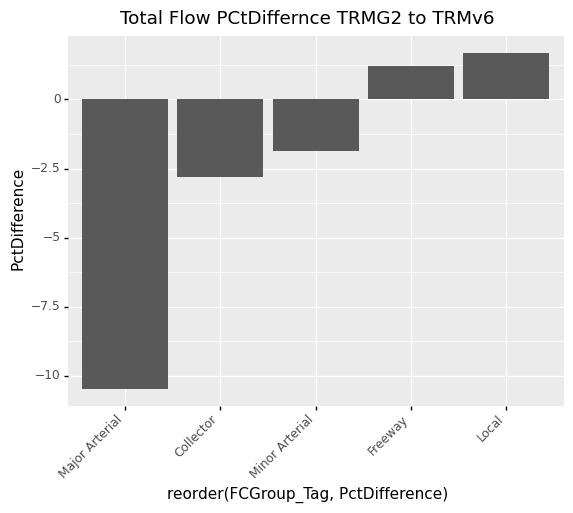

<ggplot: (95273387969)>

In [79]:
(
tot_vol_fcgroup_v6
    >>ggplot(aes('reorder(FCGroup_Tag, PctDifference)', "PctDifference"))+geom_bar(stat='identity', position='dodge')+ theme(axis_text_x = element_text(angle = 45 , hjust=1))
            +ggtitle("Total Flow PCtDiffernce TRMG2 to TRMv6")
)


## TRMG2

In [77]:
##Recreate count_comparison_by_ft_and_at.csv 


count_comparison_by_ft_and_at = (
hwy_2016_g2 
    >>filter(_.HCMType !="CC")
    >>filter(_.DailyCount>0)
    >>group_by(_.HCMType)
    >>summarize(n = _.DailyCount.count(),
                TotalVolume =_.Total_Flow_Daily.sum(),
                TotalCounts = _.DailyCount.sum())
    >>mutate(PctDifference = (_.TotalVolume - _.TotalCounts)/_.TotalVolume*100)
    >>arrange(-_.PctDifference)
  

)

count_comparison_by_ft_and_at

,HCMType,n,TotalVolume,TotalCounts,PctDifference
7,TLHighway,77,754823.495,693600,8.111
3,Local,450,1170734.336,1132520,3.264
5,MajorArterial,869,19183169.068,19173297,0.051
4,MLHighway,115,2279768.150,2297000,-0.756
2,Freeway,355,13312653.779,13827057,-3.864
0,Arterial,1625,12750021.725,13727423,-7.666
6,MajorCollector,258,1103754.509,1206180,-9.280
1,Collector,778,2354215.415,2584541,-9.784


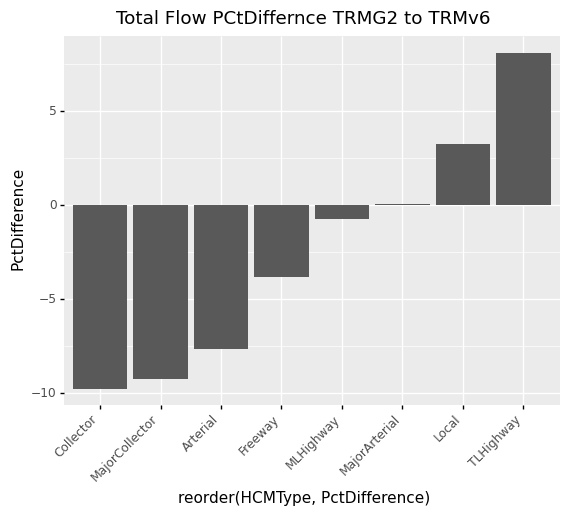

<ggplot: (95307830297)>

In [78]:
(
count_comparison_by_ft_and_at
    >>ggplot(aes('reorder(HCMType, PctDifference)', "PctDifference"))+geom_bar(stat='identity', position='dodge')+ theme(axis_text_x = element_text(angle = 45 , hjust=1))
            +ggtitle("Total Flow PCtDiffernce TRMG2 to TRMv6")
)
